In [1]:
from supervision.tools.detections import Detections, BoxAnnotator

In [2]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
model.fuse()

YOLO11n summary (fused): 238 layers, 2,616,248 parameters, 0 gradients, 6.5 GFLOPs


In [3]:
class_names = model.model.names
print(class_names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

In [4]:
count_vehicles = {
    "car" : 0,
    "bicyle" : 0,
    "motorcycle" : 0,
    "bus" : 0,
    "truck" : 0
}

In [5]:
results = model("traffic.jpg")
# print(results[0].boxes)


image 1/1 /home/ubuntu/learn/vehicle-classification/traffic.jpg: 384x640 4 cars, 2 trucks, 118.1ms
Speed: 4.6ms preprocess, 118.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


In [6]:
results = model("traffic.jpg")
detections = Detections(
    xyxy=results[0].boxes.xyxy.cpu().numpy(),
    confidence=results[0].boxes.conf.cpu().numpy(),
    class_id=results[0].boxes.cls.cpu().numpy().astype(int),
)

for i in range(len(detections)):
    class_name = class_names[detections.class_id[i]]
    count_vehicles[class_name] += 1

print(count_vehicles)


image 1/1 /home/ubuntu/learn/vehicle-classification/traffic.jpg: 384x640 4 cars, 2 trucks, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)
{'car': 4, 'bicyle': 0, 'motorcycle': 0, 'bus': 0, 'truck': 2}


In [7]:
def update_count(image):
    count_vehicles = {
        "car": 0,
        "bicyle": 0,
        "motorcycle": 0,
        "bus": 0,
        "truck": 0
    }
    
    results = model(image)
    detections = Detections(
        xyxy=results[0].boxes.xyxy.cpu().numpy(),
        confidence=results[0].boxes.conf.cpu().numpy(),
        class_id=results[0].boxes.cls.cpu().numpy().astype(int),
    )
    
    for i in range(len(detections)):
        class_name = class_names[detections.class_id[i]]
        if class_name in count_vehicles:
            count_vehicles[class_name] += 1
    
    total = sum(count_vehicles.values())
    return total


In [8]:
update_count("traffic.jpg")


image 1/1 /home/ubuntu/learn/vehicle-classification/traffic.jpg: 384x640 4 cars, 2 trucks, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)


6

In [9]:
import requests
from bs4 import BeautifulSoup
import os
import pandas as pd
import re

def getdata(url):
    r = requests.get(url)
    return r.text

districts = ['woodlands', 'kje', 'bke', 'aye', 'cte', 'sle', 'stg', 'kpe', 'pie', 'ecp', 'mce', 'ltm']
time_pattern = r'\b(\d{2}:\d{2}:\d{2})\b'

def extract_images_and_timestamps():
    data = []

    if not os.path.exists('./images'):
        os.makedirs('./images')

    for district in districts:
        url = f"https://onemotoring.lta.gov.sg/content/onemotoring/home/driving/traffic_information/traffic-cameras/{district}.html#trafficCameras"
        htmldata = getdata(url)
        soup = BeautifulSoup(htmldata, 'html.parser')

        timestamp_div = soup.find('div', class_='timestamp')
        timestamp_text = timestamp_div.get_text(strip=True) if timestamp_div else "No timestamp found"
        match = re.search(time_pattern, timestamp_text)
        if match:
            extracted_time = match.group(1)
        for item in soup.find_all('img'):
            vehicle_cnt = 0
            if item['src'].startswith("//datamall"):
                img_url = "http:" + item['src']
                img_data = requests.get(img_url).content

                district_folder = f'./images/{district}'
                if not os.path.exists(district_folder):
                    os.makedirs(district_folder)
                img_path = f'{district_folder}/{item["src"].split("/")[-1]}'
                with open(img_path, 'wb') as handler:
                    handler.write(img_data)
                vehicle_cnt = update_count(img_path)
                
        
        data.append({
        'timestamp': extracted_time,
        'district': district,
        'total_vehicle': vehicle_cnt
        })            

    df = pd.DataFrame(data)
    return df

# df = extract_images_and_timestamps()
# df.to_csv('collected_data.csv', index=False)
# df.head()

```markdown
**Note:** The following cell is commented out to prevent it from running. Uncomment the lines if you wish to execute the code.

```

In [29]:
# import time

# all_data = []

# for _ in range(60):
#     df = extract_images_and_timestamps()
#     all_data.append(df)
#     time.sleep(60)

# final_df = pd.concat(all_data, ignore_index=True)

# final_df.to_csv('collected_data.csv', index=False)


image 1/1 /home/ubuntu/learn/vehicle-classification/images/woodlands/4703_2353_20241021235410_edae9b.jpg: 384x640 1 traffic light, 7.6ms
Speed: 1.4ms preprocess, 7.6ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ubuntu/learn/vehicle-classification/images/woodlands/4713_2352_20241021235411_9a0ecb.jpg: 384x640 1 person, 1 train, 1 traffic light, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ubuntu/learn/vehicle-classification/images/woodlands/2701_2353_20241021235405_a2d3a9.jpg: 384x640 3 cars, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ubuntu/learn/vehicle-classification/images/woodlands/2702_2353_20241021235405_2e0103.jpg: 384x640 6 cars, 1 truck, 1 traffic light, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/ubuntu/learn/vehicle

In [30]:
final_df.head()

,timestamp,district,total_vehicle
0,23:54:11,woodlands,7
1,23:54:16,kje,0
2,23:54:06,bke,1
3,23:54:11,aye,0
4,23:54:06,cte,4


In [31]:
final_df.shape

(720, 3)

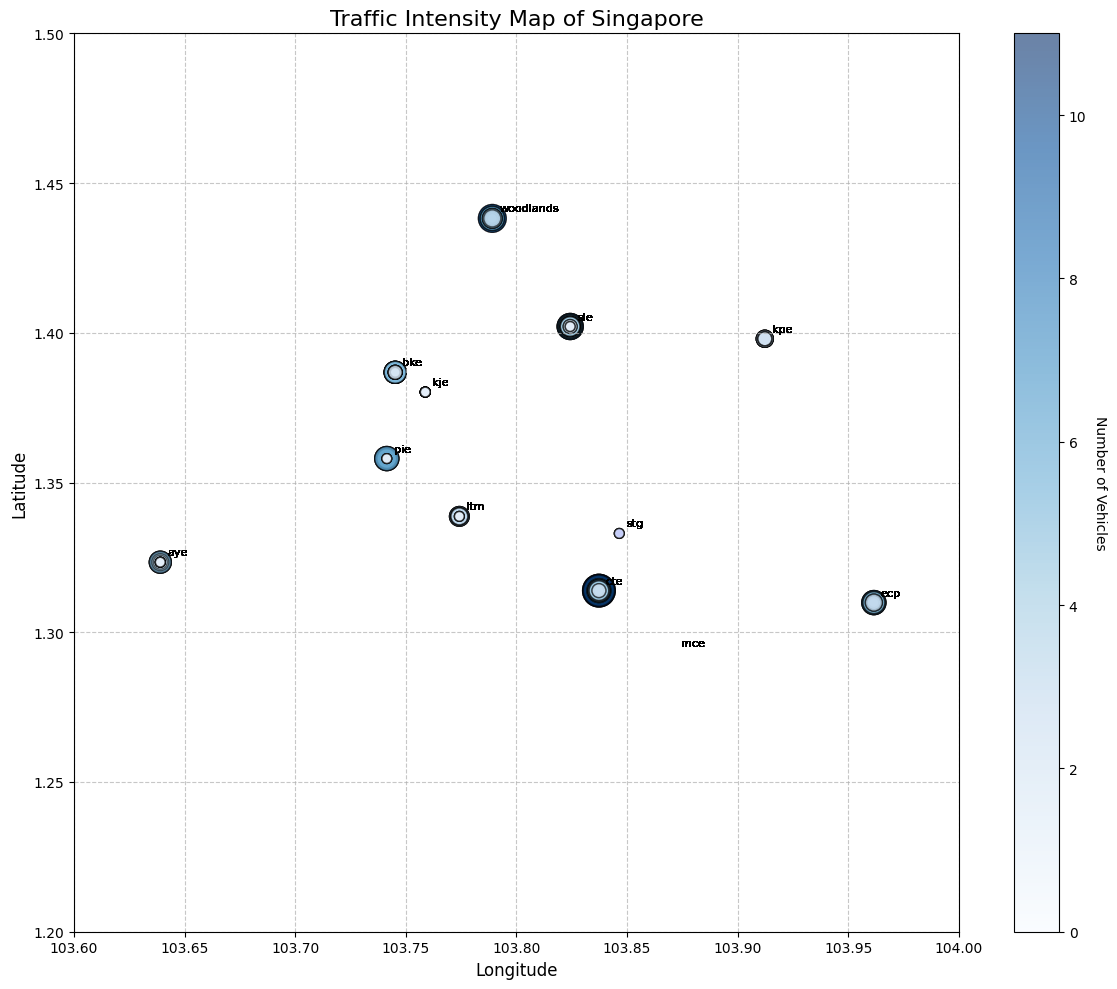

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('collected_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%H:%M:%S')

district_coordinates = {
    'woodlands': (1.4382, 103.7891),
    'kje': (1.3802, 103.7588),
    'bke': (1.3868, 103.7452),
    'aye': (1.3234, 103.6390),
    'cte': (1.3139, 103.8373),
    'sle': (1.4021, 103.8243),
    'stg': (1.3330, 103.8465),
    'kpe': (1.3980, 103.9123),
    'pie': (1.3580, 103.7414),
    'ecp': (1.3099, 103.9616),
    'mce': (1.2932, 103.8713),
    'ltm': (1.3387, 103.7742)
}

df['latitude'] = df['district'].map(lambda x: district_coordinates[x][0])
df['longitude'] = df['district'].map(lambda x: district_coordinates[x][1])

plt.figure(figsize=(12, 10))
plt.scatter(df['longitude'], df['latitude'], s=df['total_vehicle']*50, alpha=0.6, c='blue', edgecolors='black')

for idx, row in df.iterrows():
    plt.annotate(row['district'], (row['longitude'], row['latitude']), xytext=(5, 5), 
                 textcoords='offset points', fontsize=8, alpha=0.8)

plt.title('Traffic Intensity Map of Singapore', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(103.6, 104.0)
plt.ylim(1.2, 1.5)

scatter = plt.scatter(df['longitude'], df['latitude'], s=df['total_vehicle']*50, alpha=0.6, c=df['total_vehicle'], cmap='Blues', edgecolors='black')
cbar = plt.colorbar(scatter)
cbar.set_label('Number of Vehicles', rotation=270, labelpad=15)

plt.tight_layout()
plt.show()


In [12]:
import folium
from folium.plugins import TimestampedGeoJson

m = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

for index, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['total_vehicle'] * 2,  
        popup=f"District: {row['district']}<br>Timestamp: {row['timestamp']}<br>Vehicles: {row['total_vehicle']}",
        tooltip=row['district'],
        color='red',
        fill=True,
        fillColor='red',
        fillOpacity=0.7
    ).add_to(m)

m.save('traffic_intensity_map.html')
m

In [13]:
m = folium.Map(location=[1.3521, 103.8198], zoom_start=11)

features = []
for _, row in df.iterrows():
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']]
        },
        'properties': {
            'time': row['timestamp'].isoformat(),
            'popup': f"District: {row['district']}<br>Vehicles: {row['total_vehicle']}",
            'icon': 'circle',
            'iconstyle': {
                'fillColor': 'red',
                'fillOpacity': 0.7,
                'stroke': 'true',
                'radius': row['total_vehicle'] * 2
            }
        }
    }
    features.append(feature)

timestamped_geojson = TimestampedGeoJson(
    {
        'type': 'FeatureCollection',
        'features': features
    },
    period='PT1M',
    add_last_point=True,
    auto_play=False,
    loop=False
)

timestamped_geojson.add_to(m)
m.save('traffic_intensity_slider_map.html')
m


In [14]:
import os

def get_dir_size(directory):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(directory):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            total_size += os.path.getsize(fp)
    return total_size

# Example usage
directory = './images'
size_in_bytes = get_dir_size(directory)
size_in_megabytes = size_in_bytes / (1024 * 1024)
print(f"Size of '{directory}' directory: {size_in_megabytes:.2f} MB")

Size of './images' directory: 486.23 MB
